# Pre-processing

In [ ]:
# Following is the preprocessing code
from lxml import etree
import pandas as pd

def extract_data_from_xml(xml_file):
    parser = etree.XMLParser(recover=True)
    tree = etree.parse(xml_file, parser=parser)
    root = tree.getroot()

    data = []

    for row in root.findall('.//row'):
        accepted_answer_id = row.get('AcceptedAnswerId')

        if accepted_answer_id:
            question_id = row.get('Id')
            question_title = row.get('Title')
            question_body = row.get('Body')
            question_tags = row.get('Tags')

            accepted_answer_row = root.find(f'.//row[@Id="{accepted_answer_id}"]')

            if accepted_answer_row is not None:
                accepted_answer_body = accepted_answer_row.get('Body')
                data.append({
                    'Question Title': question_title,
                    'Question Body': question_body,
                    'Question Tags': question_tags,
                    'Accepted Answer Body': accepted_answer_body
                })

    return data

def save_to_excel(data, output_file):
    df = pd.DataFrame(data)
    df.to_excel(output_file, index=False)

# Replace 'input.xml' and 'output.xlsx' with your actual file paths
input_xml_file = 'Posts.xml'
output_excel_file = 'output.xlsx'

# Extract data from XML and save to Excel
data = extract_data_from_xml(input_xml_file)
save_to_excel(data, output_excel_file)

OSError: Error reading file 'Posts.xml': failed to load external entity "Posts.xml"

In [ ]:
!pip install openpyxl
!pip install pandas beautifulsoup4
import pandas as pd
from bs4 import BeautifulSoup

def html_to_text(html):
    """Convert HTML to plain text."""
    soup = BeautifulSoup(html, 'html.parser')
    # Find all anchor tags
    for a_tag in soup.find_all('a'):
        # Replace the anchor tag with its href attribute (link)
        a_tag.replace_with(a_tag.get('href'))
    return soup.get_text()

def convert_excel_html_to_text(file_path):
    """Convert HTML content in Excel cells to plain text."""
    # Read the Excel file into a pandas DataFrame
    df = pd.read_excel(file_path)

    # Iterate through each cell in the DataFrame
    for index, row in df.iterrows():
        for column in df.columns:
            cell_value = row[column]
            if isinstance(cell_value, str) and '<' in cell_value:
                # If the cell contains HTML, convert it to plain text
                plain_text = html_to_text(cell_value)
                # Replace the cell value with the plain text
                df.at[index, column] = plain_text

    # Save the modified DataFrame back to an Excel file
    output_file = "output_" + file_path
    df.to_excel(output_file, index=False)
    print(f"Converted HTML content in '{file_path}' to plain text. Output saved to '{output_file}'.")

# Example usage:
if __name__ == "__main__":
    excel_file_path = "xyz.xlsx"  # Provide the path to your Excel file
    convert_excel_html_to_text(excel_file_path)


Converted HTML content in 'xyz.xlsx' to plain text. Output saved to 'output_xyz.xlsx'.


# Evaluating the responses of LLMs and Human

In [ ]:
!pip install pandas
!pip install transformers
!pip install sentence-transformers
!pip install bert-score
!pip install nltk
!pip install bert-score
!pip  install rouge-score

import pandas as pd
from sentence_transformers import SentenceTransformer
from bert_score import BERTScorer
from rouge_score import rouge_scorer
from nltk.translate import meteor_score
from sentence_transformers import SentenceTransformer, util

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4350b08f015b5c181bcc6323deabf58147fb87fb15b4a3badf6414e658520a95
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
excel_file = 'Response_200_Samples.xlsx'

df = pd.read_excel(excel_file)
df.head()

,Question Title,Question Body,Question Tags,Accepted Answer Body,Mistral,Falcon,Llama-2
0,What open-source books (or other materials) pr...,"As a researcher and instructor, I'm looking fo...",<education><open-source>,"One book that's freely available is ""The Eleme...",I recommend checking out the following open-so...,"As an AI assistant, I suggest the following op...","As a researcher and instructor, you may find t..."
1,Is Data Science the Same as Data Mining?,I am sure data science as will be discussed in...,<data-mining><definitions>,https://datascience.stackexchange.com/users/36...,Data Science and Data Mining are related but n...,Data science is a field which involves the use...,Thank you for your question! Data Science and ...
2,Use liblinear on big data for semantic analysis,I use http://www.csie.ntu.edu.tw/~cjlin/libsvm...,<machine-learning><bigdata><libsvm>,Note that there is an early version of LIBLINE...,While Liblinear's release last year improved p...,There are a few other methods that can improve...,Thank you for sharing your concern! Liblinear ...
3,How big is big data?,Lots of people use the term big data in a rath...,<bigdata><scalability><efficiency><performance>,To me (coming from a relational database backg...,"The term ""big data"" is commonly used to descri...",Big data refers to large datasets that can be ...,"The term ""big data"" typically refers to datase..."
4,The data in our relational DBMS is getting big...,We created a social network application for eL...,<nosql><relational-dbms>,"A few gigabytes is not very ""big"". It's more l...",While your relational DBMS (SQL Server 2008) h...,It is certainly possible that moving to a NoSQ...,Thanks for sharing your project details! When ...


Comparison among Falco, Mistral and LLama2

In [ ]:
scores_df = pd.DataFrame(columns=['Model Type', 'Cosine Similarity', 'Rouge-L'])

human_responses = df['Accepted Answer Body'].tolist()
mistral_responses = df['Mistral'].tolist()
falcon_responses = df['Falcon'].tolist()
Llama2_responses = df['Llama-2'].tolist()



# Define a function to compute Cosine Similarity using sentence-transformers
def cosine_similarity_score(sentences1, sentences2):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cos_scores.numpy().diagonal()

# Define a function to compute BLEURT score using BERTScore
def bleurt_score(sentences1, sentences2):
    scorer = BERTScorer(lang="en")
    _, _, bleurt_scores = scorer.score(sentences1, sentences2)
    return bleurt_scores.numpy()

# Define a function to compute Rouge-L score
def rouge_l_score(sentences1, sentences2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(s1, s2)['rougeL'].fmeasure for s1, s2 in zip(sentences1, sentences2)]
    return rouge_scores

# Define a function to compute BERTScore
def bert_score(sentences1, sentences2):
    scorer = BERTScorer(lang="en")
    _, _, bert_scores = scorer.score(sentences1, sentences2)
    return bert_scores.numpy()


mistral_cosine_scores = cosine_similarity_score(human_responses, mistral_responses)
# mistral_bleurt_scores = bleurt_score(human_responses, mistral_responses)
mistral_rouge_l_scores = rouge_l_score(human_responses, mistral_responses)
# mistral_bert_scores = bert_score(human_responses, mistral_responses)

# Compute the average score for each metric
avg_mistral_cosine_similarity = sum(mistral_cosine_scores) / len(mistral_cosine_scores)
# avg_mistral_bleurt = sum(mistral_bleurt_scores) / len(mistral_bleurt_scores)
avg_mistral_rouge_l = sum(mistral_rouge_l_scores) / len(mistral_rouge_l_scores)
# avg_mistral_bert_score = sum(mistral_bert_scores) / len(mistral_bert_scores)



# Append a row to the DataFrame
scores_df = scores_df.append({
    'Model Type': "Mixtral",
    'Cosine Similarity': avg_mistral_cosine_similarity,
    # 'BLEURT': avg_mistral_bleurt,
    'Rouge-L': avg_mistral_rouge_l
}, ignore_index=True)



falcon_responses = [element for element in falcon_responses if not isinstance(element, float)]

falcon_cosine_scores = cosine_similarity_score(human_responses, falcon_responses)
# falcon_bleurt_scores = bleurt_score(human_responses, falcon_responses)
falcon_rouge_l_scores = rouge_l_score(human_responses, falcon_responses)
# falcon_bert_scores = bert_score(human_responses, falcon_responses)


# Compute the average score for each metric
avg_falcon_cosine_similarity = sum(falcon_cosine_scores) / len(falcon_cosine_scores)
# avg_falcon_bleurt = sum(falcon_bleurt_scores) / len(falcon_bleurt_scores)
avg_falcon_rouge_l = sum(falcon_rouge_l_scores) / len(falcon_rouge_l_scores)
# avg_falcon_bert_score = sum(falcon_bert_scores) / len(falcon_bert_scores)


# Append a row to the DataFrame
scores_df = scores_df.append({
   'Model Type': "Falcon",
   'Cosine Similarity': avg_falcon_cosine_similarity,
  #  'BLEURT': avg_falcon_bleurt,
   'Rouge-L': avg_falcon_rouge_l,
  #  'BERTScore': avg_falcon_bert_score
}, ignore_index=True)



Llama2_responses = [element for element in Llama2_responses if not isinstance(element, float)]

Llama2_cosine_scores = cosine_similarity_score(human_responses, Llama2_responses)
# Llama2_bleurt_scores = bleurt_score(human_responses, Llama2_responses)
Llama2_rouge_l_scores = rouge_l_score(human_responses, Llama2_responses)
# Llama2_bert_scores = bert_score(human_responses, Llama2_responses)


# Compute the average score for each metric
avg_Llama2_cosine_similarity = sum(Llama2_cosine_scores) / len(Llama2_cosine_scores)
# avg_Llama2_bleurt = sum(Llama2_bleurt_scores) / len(Llama2_bleurt_scores)
avg_Llama2_rouge_l = sum(Llama2_rouge_l_scores) / len(Llama2_rouge_l_scores)
# avg_Llama2_bert_score = sum(Llama2_bert_scores) / len(Llama2_bert_scores)


# Append a row to the DataFrame
scores_df = scores_df.append({
   'Model Type': "llama2",
   'Cosine Similarity': avg_Llama2_cosine_similarity,
   'Rouge-L': avg_Llama2_rouge_l,
}, ignore_index=True)


print(scores_df)

<ipython-input-26-65ff79316d61>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
<ipython-input-26-65ff79316d61>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


  Model Type  Cosine Similarity   Rouge-L
0    Mixtral           0.558765  0.131091
1     Falcon           0.449029  0.124078
2     llama2           0.303240  0.112549


<ipython-input-26-65ff79316d61>:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


In [ ]:
import pandas as pd
excel_file = 'Response_200_Samples(Reddit Data).xlsx'

df = pd.read_excel(excel_file)
df.head()

,Question Body,Accepted Answer Body,Mistral,Falcon,Llama-2
0,"Is ""open source data science"" a thing? Are the...",Try /r/datasets,"Absolutely, ""open source data science"" is a th...",Open source data science is a rapidly growing ...,Absolutely! Open source data science is defini...
1,Career Advice,Are you getting feedback from employers that y...,I'm glad to see you're seeking career advice. ...,"Choosing a career can be a difficult decision,...",Title: Exploring New Career Options? Here Are ...
2,Designing Easy to Understand Dashboards,Humans are very good at extracting meaning fro...,Creating easy-to-understand dashboards require...,"When designing a dashboard, it is important to...","When designing easy-to-understand dashboards, ..."
3,What's the mix of software used in r/datascience?,in decreasing order of daily usage from this w...,"In the r/datascience community, there isn't a ...",The mix of software used in r/datascience is a...,The majority of the data science community on ...
4,Google Refine query,My understanding is Google Refine runs in your...,I'd be happy to help you with your Google Refi...,The forum poster has asked a great question an...,Title: Using Google Refine to Clean and Transf...


In [ ]:
scores_df = pd.DataFrame(columns=['Model Type', 'Cosine Similarity', 'Rouge-L'])

human_responses = df['Accepted Answer Body'].tolist()
mistral_responses = df['Mistral'].tolist()
falcon_responses = df['Falcon'].tolist()
Llama2_responses = df['Llama-2'].tolist()



# Define a function to compute Cosine Similarity using sentence-transformers
def cosine_similarity_score(sentences1, sentences2):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cos_scores.numpy().diagonal()

# Define a function to compute BLEURT score using BERTScore
def bleurt_score(sentences1, sentences2):
    scorer = BERTScorer(lang="en")
    _, _, bleurt_scores = scorer.score(sentences1, sentences2)
    return bleurt_scores.numpy()

# Define a function to compute Rouge-L score
def rouge_l_score(sentences1, sentences2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(s1, s2)['rougeL'].fmeasure for s1, s2 in zip(sentences1, sentences2)]
    return rouge_scores

# Define a function to compute BERTScore
def bert_score(sentences1, sentences2):
    scorer = BERTScorer(lang="en")
    _, _, bert_scores = scorer.score(sentences1, sentences2)
    return bert_scores.numpy()


mistral_cosine_scores = cosine_similarity_score(human_responses, mistral_responses)
# mistral_bleurt_scores = bleurt_score(human_responses, mistral_responses)
mistral_rouge_l_scores = rouge_l_score(human_responses, mistral_responses)
# mistral_bert_scores = bert_score(human_responses, mistral_responses)

# Compute the average score for each metric
avg_mistral_cosine_similarity = sum(mistral_cosine_scores) / len(mistral_cosine_scores)
# avg_mistral_bleurt = sum(mistral_bleurt_scores) / len(mistral_bleurt_scores)
avg_mistral_rouge_l = sum(mistral_rouge_l_scores) / len(mistral_rouge_l_scores)
# avg_mistral_bert_score = sum(mistral_bert_scores) / len(mistral_bert_scores)



# Append a row to the DataFrame
scores_df = scores_df.append({
    'Model Type': "Mixtral",
    'Cosine Similarity': avg_mistral_cosine_similarity,
    # 'BLEURT': avg_mistral_bleurt,
    'Rouge-L': avg_mistral_rouge_l
}, ignore_index=True)



falcon_responses = [element for element in falcon_responses if not isinstance(element, float)]

falcon_cosine_scores = cosine_similarity_score(human_responses, falcon_responses)
# falcon_bleurt_scores = bleurt_score(human_responses, falcon_responses)
falcon_rouge_l_scores = rouge_l_score(human_responses, falcon_responses)
# falcon_bert_scores = bert_score(human_responses, falcon_responses)


# Compute the average score for each metric
avg_falcon_cosine_similarity = sum(falcon_cosine_scores) / len(falcon_cosine_scores)
# avg_falcon_bleurt = sum(falcon_bleurt_scores) / len(falcon_bleurt_scores)
avg_falcon_rouge_l = sum(falcon_rouge_l_scores) / len(falcon_rouge_l_scores)
# avg_falcon_bert_score = sum(falcon_bert_scores) / len(falcon_bert_scores)


# Append a row to the DataFrame
scores_df = scores_df.append({
   'Model Type': "Falcon",
   'Cosine Similarity': avg_falcon_cosine_similarity,
  #  'BLEURT': avg_falcon_bleurt,
   'Rouge-L': avg_falcon_rouge_l,
  #  'BERTScore': avg_falcon_bert_score
}, ignore_index=True)



Llama2_responses = [element for element in Llama2_responses if not isinstance(element, float)]

Llama2_cosine_scores = cosine_similarity_score(human_responses, Llama2_responses)
# Llama2_bleurt_scores = bleurt_score(human_responses, Llama2_responses)
Llama2_rouge_l_scores = rouge_l_score(human_responses, Llama2_responses)
# Llama2_bert_scores = bert_score(human_responses, Llama2_responses)


# Compute the average score for each metric
avg_Llama2_cosine_similarity = sum(Llama2_cosine_scores) / len(Llama2_cosine_scores)
# avg_Llama2_bleurt = sum(Llama2_bleurt_scores) / len(Llama2_bleurt_scores)
avg_Llama2_rouge_l = sum(Llama2_rouge_l_scores) / len(Llama2_rouge_l_scores)
# avg_Llama2_bert_score = sum(Llama2_bert_scores) / len(Llama2_bert_scores)


# Append a row to the DataFrame
scores_df = scores_df.append({
   'Model Type': "llama2",
   'Cosine Similarity': avg_Llama2_cosine_similarity,
   'Rouge-L': avg_Llama2_rouge_l,
}, ignore_index=True)


print(scores_df)

<ipython-input-28-65ff79316d61>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
<ipython-input-28-65ff79316d61>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


  Model Type  Cosine Similarity   Rouge-L
0    Mixtral           0.325585  0.067888
1     Falcon           0.216017  0.067345
2     llama2           0.313956  0.072582


<ipython-input-28-65ff79316d61>:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


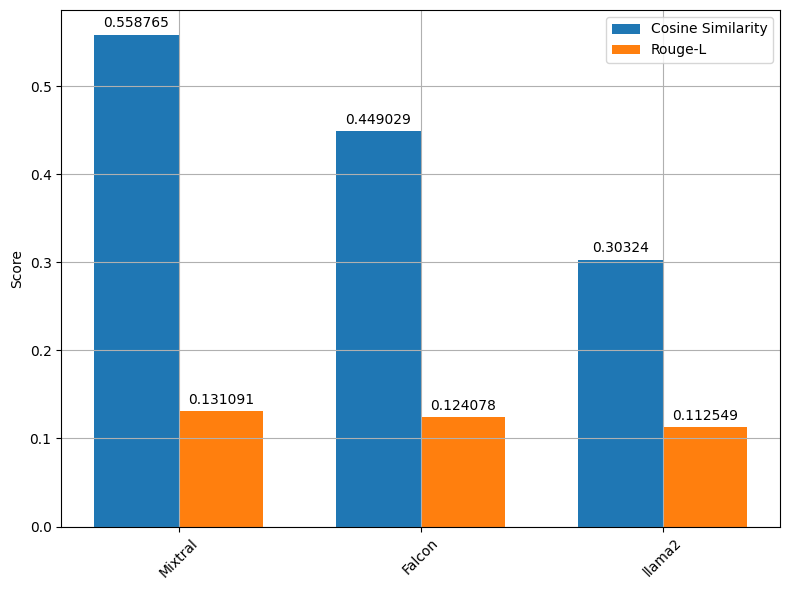

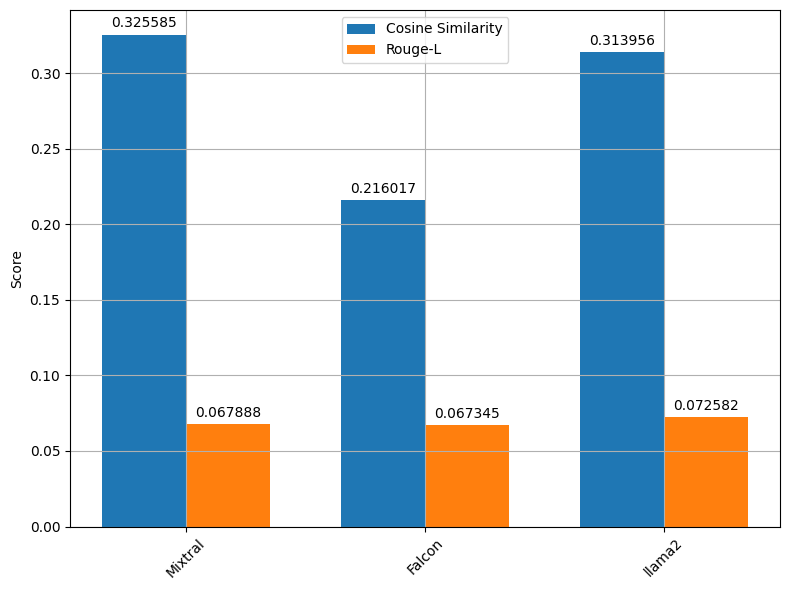

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_types = ['Mixtral', 'Falcon', 'llama2']
stackexchange_cosine_similarity = [0.558765, 0.449029, 0.303240]
stackexchange_rouge_l = [0.131091, 0.124078, 0.112549]
reddit_cosine_similarity = [0.325585, 0.216017, 0.313956]
reddit_rouge_l = [0.067888, 0.067345, 0.072582]

x = np.arange(len(model_types))  # the label locations
width = 0.35  # the width of the bars

# Plotting StackExchange data
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, stackexchange_cosine_similarity, width, label='Cosine Similarity')
rects2 = ax.bar(x + width/2, stackexchange_rouge_l, width, label='Rouge-L')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(model_types)
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Plotting Reddit data
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, reddit_cosine_similarity, width, label='Cosine Similarity')
rects2 = ax.bar(x + width/2, reddit_rouge_l, width, label='Rouge-L')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(model_types)
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

autolabel(rects1)
autolabel(rects2)

plt.show()


# Desciptive Stats

In [ ]:
import xml.etree.ElementTree as ET
from datetime import datetime

# Function to parse datetime strings
def parse_datetime(datetime_str):
    return datetime.fromisoformat(datetime_str)

# Function to find date range
def find_date_range(dates):
    if not dates:
        return None, None
    return min(dates), max(dates)

# Load XML file
tree = ET.parse('Posts.xml')
root = tree.getroot()

# Initialize variables
post_count = 0
comment_count = 0
post_dates = []
comment_dates = []

# Iterate through each row element
for row in root.findall('row'):
    post_type = row.get('PostTypeId')
    creation_date = row.get('CreationDate')
    comment_count += int(row.get('CommentCount', 0))

    if post_type == '1' and row.get('ParentId') is None:
        post_count += 1
        post_dates.append(parse_datetime(creation_date))

    if row.get('CommentCount'):
        comment_dates.extend([parse_datetime(creation_date)] * int(row.get('CommentCount')))

# Find date ranges
posts_start_date, posts_end_date = find_date_range(post_dates)
comments_start_date, comments_end_date = find_date_range(comment_dates)

# Print results
print("Number of posts:", post_count)
print("Number of comments:", comment_count)
print("Posts date range:", posts_start_date, "-", posts_end_date)
print("Comments date range:", comments_start_date, "-", comments_end_date)

In [ ]:
# Initialize variables
unique_owner_user_ids = set()

# Iterate through each row element
for row in root.findall('row'):
    owner_user_id = row.get('OwnerUserId')
    if owner_user_id:
        unique_owner_user_ids.add(owner_user_id)

# Print unique OwnerUserIds
print("Unique OwnerUserIds:", len(unique_owner_user_ids))
